<a href="https://colab.research.google.com/github/KhawajaMuddassar/object_detection-and-image-classification/blob/main/Fast_R-CNN_Based_Object_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Fast R-CNN**

Fast R-CNN passes the entire image through the pretrained model to
extract features, and then it fetches the region of features that correspond to the region proposals obtained from **selectivesearch** of the original image.
The major difference between R-CNN and Fast R-CNN is that, in R-CNN, we pass the crops (resized region proposals) through the pretrained model one at a time, while in Fast R-CNN, we crop the feature map (which is obtained by passing the whole image through a pretrained model) corresponding to each region proposal, thereby avoiding the need to pass each resized region proposal through the pretrained model.

faster rcnn.PNG

**High Level Training Process of Fast R-CNN**

Training a Fast R-CNN object detection model involves the following steps:


1.   Pass the image through a pretrained model to extract feature maps
2.   Extract region proposals corresponding to the image
2.   Extract the feature map area corresponding to the region proposals
2.   Pass the feature maps corresponding to region proposals through the region of interest (RoI) pooling layer one at a time so that all feature maps of region proposals have a similar shape. **This is a replacement for the warping that was executed in the R-CNN technique**.
2.   Pass the RoI pooling layer output value through a fully connected layer
2.   Train the model to predict the class and offsets corresponding to each region proposal


# **Implementing R-CNN object detector**

# **Download Dataset**

In [ ]:
try:
    import selectivesearch, torch, torchvision, cv2, torch.nn as nn
    from torch_snippets import *
    from torch_snippets.torch_loader import Report, DataLoader, Dataset
    from torch.optim import SGD
    from torchvision import datasets, transforms, models
    from torchvision.ops import nms
    from google.colab import files
except:
    %pip install -q --upgrade torch_snippets selectivesearch
    import selectivesearch, torch, torchvision, cv2, torch.nn as nn
    from torch_snippets import *
    from torch_snippets.torch_loader import Report, DataLoader, Dataset
    from torch.optim import SGD
    from torchvision import datasets, transforms, models
    from torchvision.ops import nms
    from google.colab import files

# Register Device
device = 'cuda' if torch.cuda.is_available() else 'cpu'
files.upload()

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!ls ~/.kaggle
!chmod 600 /root/.kaggle/kaggle.json
!kaggle datasets download -d sixhky/open-images-bus-trucks/
!unzip -qq open-images-bus-trucks.zip

root_folder = 'images/images'
data = pd.read_csv('df.csv')
data.head(3)

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 103.0/103.0 kB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 218.7/218.7 kB 15.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 162.6/162.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.0/99.0 kB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 469.0/469.0 kB 19.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 31.9 MB/s eta 0:00:00


Saving kaggle.json to kaggle.json
kaggle.json
Dataset URL: https://www.kaggle.com/datasets/sixhky/open-images-bus-trucks/versions/
License(s): unknown
 99% 364M/367M [00:20<00:00, 16.3MB/s]
100% 367M/367M [00:20<00:00, 18.6MB/s]


,ImageID,Source,LabelName,Confidence,XMin,XMax,YMin,YMax,IsOccluded,IsTruncated,...,IsDepiction,IsInside,XClick1X,XClick2X,XClick3X,XClick4X,XClick1Y,XClick2Y,XClick3Y,XClick4Y
0,0000599864fd15b3,xclick,Bus,1,0.343750,0.908750,0.156162,0.650047,1,0,...,0,0,0.421875,0.343750,0.795000,0.908750,0.156162,0.512700,0.650047,0.457197
1,00006bdb1eb5cd74,xclick,Truck,1,0.276667,0.697500,0.141604,0.437343,1,0,...,0,0,0.299167,0.276667,0.697500,0.659167,0.141604,0.241855,0.352130,0.437343
2,00006bdb1eb5cd74,xclick,Truck,1,0.702500,0.999167,0.204261,0.409774,1,1,...,0,0,0.849167,0.702500,0.906667,0.999167,0.204261,0.398496,0.409774,0.295739


# **Preparing Dataset**

This involves following steps:



1.   Fetching values of each image, its class and bounding -box
2.   Fetching RoPs within each image, thier IoU, and delta by which RoP will be correct w.r.t ground truth
3.   Assigning numeric labels for each class, also for additional background classes besides bus and truck classes where IoU with ground truth is bounding-box is lower than threshold
4.   Resizing each RoP to comman size so that we can pass it to network

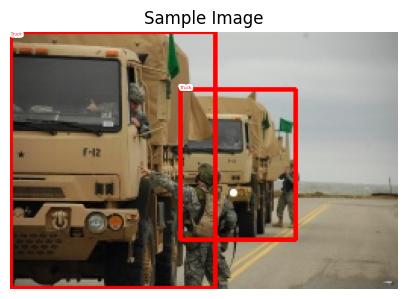

In [ ]:
import warnings
warnings.filterwarnings(action='ignore')

# Define class that return images, classes, bounding boxes along with its filepath
class GetImageData(Dataset):
    def __init__(self, data=data, image_folder= root_folder):
        self.folder = image_folder
        self. data = data
        self.unique_images = data['ImageID'].unique()
    def __len__(self): return len(self.unique_images)
    def __getitem__(self,xi):
        imageid = self.unique_images[xi]
        fpath = f'{self.folder}/{imageid}.jpg'
        image = cv2.imread(fpath,1)[...,::-1]
        h,w = image.shape[:2]
        df = self.data.copy()
        df = df[df['ImageID']==imageid]
        box = df['XMin,YMin,XMax,YMax'.split(',')].values
        box = (box*np.array([w,h,w,h])).astype(np.uint16).tolist()
        classes = df['LabelName'].values.tolist()
        return image, box, classes,fpath

# **********      End of Class *****************

# Initialize dataset and inspect samples
ds = GetImageData()
img, bbs, clss,_ = ds[214]
show(img,texts=clss, bbs=bbs,bb_colors='r',title='Sample Image')


# **Fetch region proposals and the ground truth of offset**

Input and Output corresponding to our model

**Input** = Candidate that are extracted using Selectivesearch

**Output** = Class coresponding to candidate and offset of candidate w.r.t bounding box it overlaps most with if the candiate has an object.

In [ ]:
# Define functions to extract IoUs and fetch RoPs from image
# Fetch ROI and IOU

# RoP - Candidates
def get_candidate(image):
    labels, regions = selectivesearch.selective_search(image, scale=200, min_size=100)
    area = np.prod(image.shape[:2])
    candidates = []
    for region in regions:
        if region['rect'] in candidates: continue
        if region['size'] < (0.05*area): continue
        if region['size'] > (1*area): continue
        x, y, w, h = region['rect']
        candidates.append(list(region['rect']))
    return candidates

# Intersectin Over Unions
def get_iou(BoxA, BoxB, esp=1e-5):
    x1 = max(BoxA[0],BoxB[0])
    y1 = max(BoxA[1],BoxB[1])
    x2 = min(BoxA[2],BoxB[2])
    y2 = min(BoxA[3],BoxB[3])
    width = (x2 - x1)
    height = (y2 - y1)
    if (width<0) or (height<0):
        return 0.0
    overlap_area = width * height
    a_area = (BoxA[2] - BoxA[0]) * (BoxA[3] - BoxA[1])
    b_area = (BoxB[2] - BoxB[0]) * (BoxB[3] - BoxB[1])
    combined_area = a_area + b_area - overlap_area
    iou = overlap_area / (combined_area+esp)
    return iou

# Create lists to store values
FILEPATHS, CLSS, GTBBS, IOUS, ROIS, DELTAS = [],[],[],[],[],[]

cnt = 1000 # you can increase this number of images according to  available computational resources
for xi, (image, box, classes,fpath) in enumerate(ds):
    if (xi == cnt):
        break
    H,W = image.shape[:2]
    candidates = get_candidate(image)
    candidates = np.array([(x,y, x+w, y+h) for x,y,w,h in candidates])
    ious, clss, rois, deltas = [],[],[],[]
    ious = np.array([[get_iou(candidate, _box_)for candidate in candidates]for _box_ in box]).T
    for dx, candidate in enumerate(candidates):
        cx, cy, cX, cY = candidate
        candidate_iou = ious[dx]
        best_iou_at = np.argmax(candidate_iou)
        best_iou = candidate_iou[best_iou_at]
        best_box = _x, _y, _X, _Y = box[best_iou_at]
        if best_iou>0.3:clss.append(classes[best_iou_at])
        else:clss.append('background')
        delta = np.array([_x-cx, _y-cy, _X-cX, _Y-cY]) / np.array([W,H,W,H])
        deltas.append(delta)
        rois.append(candidate/np.array([W,H,W,H]))
    FILEPATHS.append(fpath)
    CLSS.append(clss)
    GTBBS.append(box)
    IOUS.append(ious)
    ROIS.append(rois)
    DELTAS.append(deltas)

FILEPATHS = [f'{root_folder}/{stem(f)}.jpg' for f in FILEPATHS]
FILEPATHS, CLSS, GTBBS, ROIS, DELTAS = [ item for item in [FILEPATHS, CLSS, GTBBS, ROIS, DELTAS ]]

# Assign indices
targets = pd.DataFrame(flatten(CLSS), columns=['label'])
label2target = {l:t for t,l in enumerate(targets['label'].unique())}
target2label = {t:l for l,t in label2target.items()}
background_class = label2target['background']


# **Generate training data**


*   Create Dataset from ground truth region of proposals
*   Create Data Loaders
*   Resize region proposals to normalization and scaling them

In [ ]:
# Define normalization values
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

# Define function to preprocess image
def preprocess(image):
    image = torch.tensor(image).permute(2,0,1)
    image = normalize(image)
    return image.to(device).float()

# Decode predictions
def decode(_y):
    _, pred = _y.max(-1)
    return pred

# Define FRCNNDataSet class that returns images, labels, ground truths, RoP, and the delta corresponding to each RoP
class FRCNNDataSet(Dataset):
    def __init__(self, fpath, rois, clss, deltas, gtbbs):
        self.fpath = fpath
        self.rois = rois
        self.clss = clss
        self.deltas = deltas
        self.gtbbs = gtbbs
    def __len__(self): return len(self.fpath)
    def __getitem__(self,xi):
        filepath = str(self.fpath[xi])
        image = cv2.imread(filepath,1)[...,::-1]
        rois = self.rois[xi]
        clss = self.clss[xi]
        deltas = self.deltas[xi]
        gtbbs = self.gtbbs[xi]
        assert len(rois) == len(clss) == len(deltas), f'{len(rois)},{len(clss)},{len(deltas)}'
        return image, rois, clss, deltas, gtbbs, filepath
    # For batch of images processing, here we will return more information extra matrix ROIS & RIXS
    # ROIS Matrix holds info. regarding which ROI belongs to which image in a batch and is single list of boxes
    # RIXS is list of indexes, which tell us how many RoI belongs to first image and how many to second image
    def collate_batch(self,batch):
        input, rois, rixs, clss, deltas = [], [], [], [], []
        for dx in range(len(batch)):
            image,imgrois,imgclss,imgdeltas,imggtbbs,imgfpath = batch[dx]
            image = cv2.resize(image, (224,224))
            input.append(preprocess(image/255.)[None])
            rois.extend(imgrois)
            rixs.extend([dx]*len(imgrois))
            clss.extend([label2target[c] for c in imgclss])
            deltas.extend(imgdeltas)
        input = torch.cat(input)
        rois = torch.Tensor(rois).float().to(device)
        rixs = torch.Tensor(rixs).float().to(device)
        clss = torch.Tensor(clss).long().to(device)
        deltas = torch.Tensor(deltas).float().to(device)
        return input, rois, rixs, clss, deltas

# **********      End of Class *****************

# Create Training and Testing Datasets
set_cnt = 9*len(FILEPATHS)//10

train_dataset = FRCNNDataSet(
                            FILEPATHS[:set_cnt],
                            ROIS[:set_cnt],
                            CLSS[:set_cnt],
                            DELTAS[:set_cnt],
                            GTBBS[:set_cnt])
test_dataset = FRCNNDataSet(
                            FILEPATHS[set_cnt:],
                            ROIS[set_cnt:],
                            CLSS[set_cnt:],
                            DELTAS[set_cnt:],
                            GTBBS[set_cnt:])

# Data Loader
train_loader = DataLoader(train_dataset, batch_size=2, drop_last=True, collate_fn=train_dataset.collate_batch)
test_loader = DataLoader(test_dataset, batch_size=2, drop_last=True, collate_fn=test_dataset.collate_batch)

# **Fast R-CNN Network Module**

In [ ]:
from torchvision.ops import RoIPool # it takes variable-sized regions proposed by the model and convert them into fixed-size feature maps e.g (7x7 or 14x14)
import torch.nn as nn

class FRCNN(nn.Module):
    def __init__(self):
        super().__init__()
        # Load pretrained model and freeze parameters
        backbone = models.vgg16_bn(pretrained=True)
        for param in backbone.features.parameters():
            param.requires_grad=False
        # Extract features untill last layer
        self.seq = nn.Sequential(*list(backbone.features.children())[:-1])
         # Convert feature maps into fixed-size
        self.roipool = RoIPool(7,spatial_scale=14/224)  # spatial_scale is the factor byw hich proposals need to be shrunk
        # Output Head class score and bounding box
        input_dim = 512*7*7 # 25088
        self.cls_score = nn.Linear(input_dim, len(label2target))
        self.bbox = nn.Sequential(
                                nn.Linear(input_dim,512),
                                nn.ReLU(),
                                nn.Linear(512,4),
                                nn.Tanh() )
        # Loss Functions
        self.cel = nn.CrossEntropyLoss()
        self.sl1 = nn.L1Loss()

    #Feed-Forward function
    def forward(self, input, rois, ridx):
        # Pass image through pretrained model
        res = input
        res = self.seq(res)
        #Create a matrix of rois as input for self.roipool
        rois = torch.cat([ridx.unsqueeze(-1), rois*224], dim=-1)
        res = self.roipool(res, rois) # Apply ROI Pooling
        feat = res.view(len(res), -1) # Reshape Features
        cls_score = self.cls_score(feat) # Class prediction score
        bbox = self.bbox(feat) # Box prediction score
        return cls_score, bbox


    # Calculate Loss
    def calc_loss(self, probs, _deltas, cls_labels, deltas):
        detection_loss = self.cel(probs, cls_labels)
        fltr = torch.where(cls_labels != background_class)
        _deltas = _deltas[fltr]
        deltas = deltas[fltr]
        self.lmb=10.0
        if len(fltr)>0:
            regression_loss = self.sl1(_deltas, deltas)
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss.detach()
        else:
            regression_loss =0
            return detection_loss + self.lmb * regression_loss, detection_loss.detach(), regression_loss

# **********      End of Class *****************


# **Model Training**

Train model over increasing epochs

In [ ]:
# Traiing Model

def train_batch(inputs, model, optimizer, criterion):
    input, rois, rixs, clss, deltas = inputs
    model.train()
    optimizer.zero_grad()
    _clss, _deltas = model(input, rois, rixs)
    loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas)
    accs = clss == decode(_clss)
    loss.backward()
    optimizer.step()
    return loss.detach(), loc_loss, regr_loss,accs.cpu().numpy()

@torch.no_grad()
def validate_batch(inputs, model, criterion):
    input, rois, rixs, clss, deltas = inputs
    with torch.no_grad():
        model.eval()
        _clss, _deltas = model(input, rois, rixs)
        loss, loc_loss, regr_loss = criterion(_clss, _deltas, clss, deltas )
        accs = clss == decode(_clss)
        return _clss,_deltas, loss.detach(),loc_loss,regr_loss,accs.cpu().numpy()

frcnn = FRCNN().to(device)
criterion = frcnn.calc_loss
optimizer = torch.optim.SGD(frcnn.parameters(), lr=1e-3)

# Train over increasing epochs
epochs = 5
log = Report(epochs)

for epoch in range(epochs):

    _n = len(train_loader)
    for ix, inputs in enumerate(train_loader):
        loss, loc_loss, regr_loss, accs = train_batch(inputs, frcnn, optimizer, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, trn_loss=loss.item(), trn_loc_loss=loc_loss, trn_regr_loss=regr_loss, trn_acc=accs.mean(), end='\r')

    _n = len(test_loader)
    for ix,inputs in enumerate(test_loader):
        _clss, _deltas, loss,loc_loss, regr_loss, accs = validate_batch(inputs, frcnn, criterion)
        pos = (epoch + (ix+1)/_n)
        log.record(pos, val_loss=loss.item(), val_loc_loss=loc_loss, val_regr_loss=regr_loss,  val_acc=accs.mean(), end='\r')

    log.report_avgs(epoch+1)


EPOCH: 1.000  val_acc: 0.781  val_loc_loss: 0.568  trn_regr_loss: nan  val_regr_loss: nan  val_loss: nan  trn_acc: 0.866  trn_loss: nan  trn_loc_loss: 0.388  (12.04s - 48.14s remaining)
EPOCH: 2.000  val_acc: 0.780  val_loc_loss: 0.584  trn_regr_loss: nan  val_regr_loss: nan  val_loss: nan  trn_acc: 0.876  trn_loss: nan  trn_loc_loss: 0.368  (23.99s - 35.98s remaining)
EPOCH: 3.000  val_acc: 0.780  val_loc_loss: 0.587  trn_regr_loss: nan  val_regr_loss: nan  val_loss: nan  trn_acc: 0.885  trn_loss: nan  trn_loc_loss: 0.350  (35.88s - 23.92s remaining)
EPOCH: 4.000  val_acc: 0.779  val_loc_loss: 0.591  trn_regr_loss: nan  val_regr_loss: nan  val_loss: nan  trn_acc: 0.891  trn_loss: nan  trn_loc_loss: 0.335  (47.69s - 11.92s remaining)
EPOCH: 5.000  val_acc: 0.781  val_loc_loss: 0.595  trn_regr_loss: nan  val_regr_loss: nan  val_loss: nan  trn_acc: 0.896  trn_loss: nan  trn_loc_loss: 0.322  (59.51s - 0.00s remaining)


# **Make prediction on a test image**

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
import matplotlib.patches as mpatches
from torchvision.ops import nms
from PIL import Image

# Define prediction function to takes a filename as input and then reads the file and resizes it to 224 x 224
def test_predictions(filename):
    img = cv2.resize(np.array(Image.open(filename)), (224,224))
    candidates = get_candidate(img)
    candidates = [(x,y,x+w,y+h) for x,y,w,h in candidates]
    input = preprocess(img/255.)[None]
    rois = [[x/224,y/224,X/224,Y/224] for x,y,X,Y in candidates]
    rixs = np.array([0]*len(rois))
    #Forward-propagate the input, RoIs through the trained model
    rois, rixs = [torch.Tensor(item).to(device) for item in [rois, rixs]]
    with torch.no_grad():
        frcnn.eval()
        probs, deltas = frcnn(input, rois, rixs)
        confs, clss = torch.max(probs, -1)
    #Filter out the background class
    candidates = np.array(candidates)
    confs, clss, probs, deltas = [tensor.detach().cpu().numpy() for tensor in [confs, clss, probs, deltas]]
    ixs = clss!=background_class
    confs, clss, probs, deltas, candidates = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates]]
    bbs = candidates + deltas
    # Remove near-duplicate bounding boxes with nms
    ixs = nms(torch.tensor(bbs.astype(np.float32)), torch.tensor(confs), 0.05)
    confs, clss, probs, deltas, candidates, bbs = [tensor[ixs] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    if len(ixs) == 1:
        confs, clss, probs, deltas, candidates, bbs = [tensor[None] for tensor in [confs, clss, probs, deltas, candidates, bbs]]
    # Plot the bounding boxes
    bbs = bbs.astype(np.uint16)
    _, ax = plt.subplots(1, 2, figsize=(10,10))
    show(img, ax=ax[0])
    ax[0].grid(False)
    ax[0].set_title(filename.split('/')[-1])
    if len(confs) == 0:
        ax[1].imshow(img)
        ax[1].set_title('No objects')
        plt.show()
        return
    else:
        show(img, bbs=bbs.tolist(), texts=[target2label[c] for c in clss.tolist()], ax=ax[1])
        plt.show()

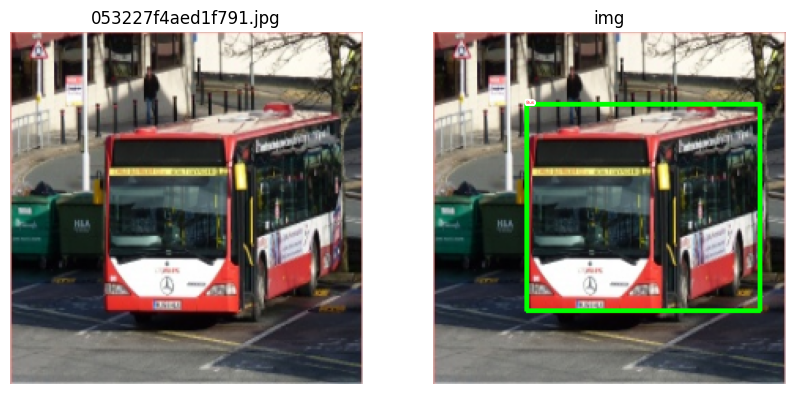

In [ ]:
# Call function
test_predictions(test_dataset[2][-1])